# 1. Libraries and data importation

In [75]:
# Import libraries for math and data processing
import numpy as np
import pandas as pd

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for feature engineering
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, learning_curve, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, StackingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, SGDRegressor

# Visualize diagrams for sklearn objects
set_config(display = 'diagram')

# Import librarie for statistics
import scipy.stats as stats
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

# Import libraries for ML
import xgboost as xgb
from xgboost import (XGBRegressor, cv as XGBcv)
from lightgbm import (LGBMRegressor, cv as LGBMcv)
from catboost import (CatBoostRegressor, cv as CBcv)


# Set a globally used random seed for every method
rand_seed = 123

# Change to 0 to disable below graph functions
enable_graphs = 1

# Function used to plot correlation heatmap
def plot_corr_heatmap(df, mtd = 'pearson', size = (50,50), n_important = 10):
    
    if enable_graphs == 0:
        print('Heatmap Graph disabled')
        return
    
    important_cols = df.corr(method = mtd).nlargest(n_important, 'SalePrice')['SalePrice'].index
    
    fig, ax = plt.subplots(figsize = size)
    sns.set(font_scale = 6)
    sns.heatmap(
                    data       = df[important_cols].corr(method = mtd), 
                    annot      = True, 
                    annot_kws  = {'fontsize' : 10},
                    linewidths = 0.7, 
                    linecolor  = 'black', 
                    square     = True, 
                    ax         = ax, 
                    cbar       = False, 
                    fmt        = '.3f', 
                    cmap       = 'coolwarm', 
                    robust     = True
                )
    plt.show()
    sns.reset_orig()
    return 

def plot_skewness(df, figsize = (30,8), title = ''):
    
    if enable_graphs == 0:
        print('Skewness Graph disabled')
        return
    
    ax = df.skew().plot(
                            kind    = 'bar', 
                            figsize = figsize,
                            xlabel  = 'Variables', 
                            ylabel  = 'Skewness',
                            title   = title,
                            grid    = False,
                            rot     = 90
                        )

    for container in ax.containers:
        ax.bar_label(container, fmt = '%.3f', padding = 5)
        
    return plt.show()

# Function used to perform a normality check
def normality_test(df):
    normality_test = pd.DataFrame(data = {'Feature' : df.columns, 
                                          'Shapiro Statistic': '', 
                                          'Shapiro p-value' : '', 
                                          'Anderson-Darling Statistic' : '', 
                                          'Anderson-Darling Critical Value (1%)' : ''
                                         })

    for feature in normality_test['Feature']:
        normality_test['Shapiro Statistic'] = stats.shapiro(df[feature])[0]
        normality_test['Shapiro p-value']   = stats.shapiro(df[feature])[1]
        
        normality_test['Anderson-Darling Statistic']           = stats.anderson(df[feature])[0]
        normality_test['Anderson-Darling Critical Value (1%)'] = stats.anderson(df[feature])[1][4]

    return normality_test

# Function used to average predictions
def average_predictions(preds1, preds2, mtd = 'log'):
    if mtd == 'log':
        avrg = np.exp((np.log(preds1) + np.log(preds2))/2)
    else:
        avrg = np.average([preds1, preds2])
    
    return avrg

# 2. Data visualization (EDA)
Let's take a look at the dataset

In [2]:
# Load data in a DataFrame
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
# Visualize some train data
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
# Visualize some test data
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [5]:
# Visualize the shape of the data
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

¿How many features do we have with missing values? ¿How many missing values do they have?

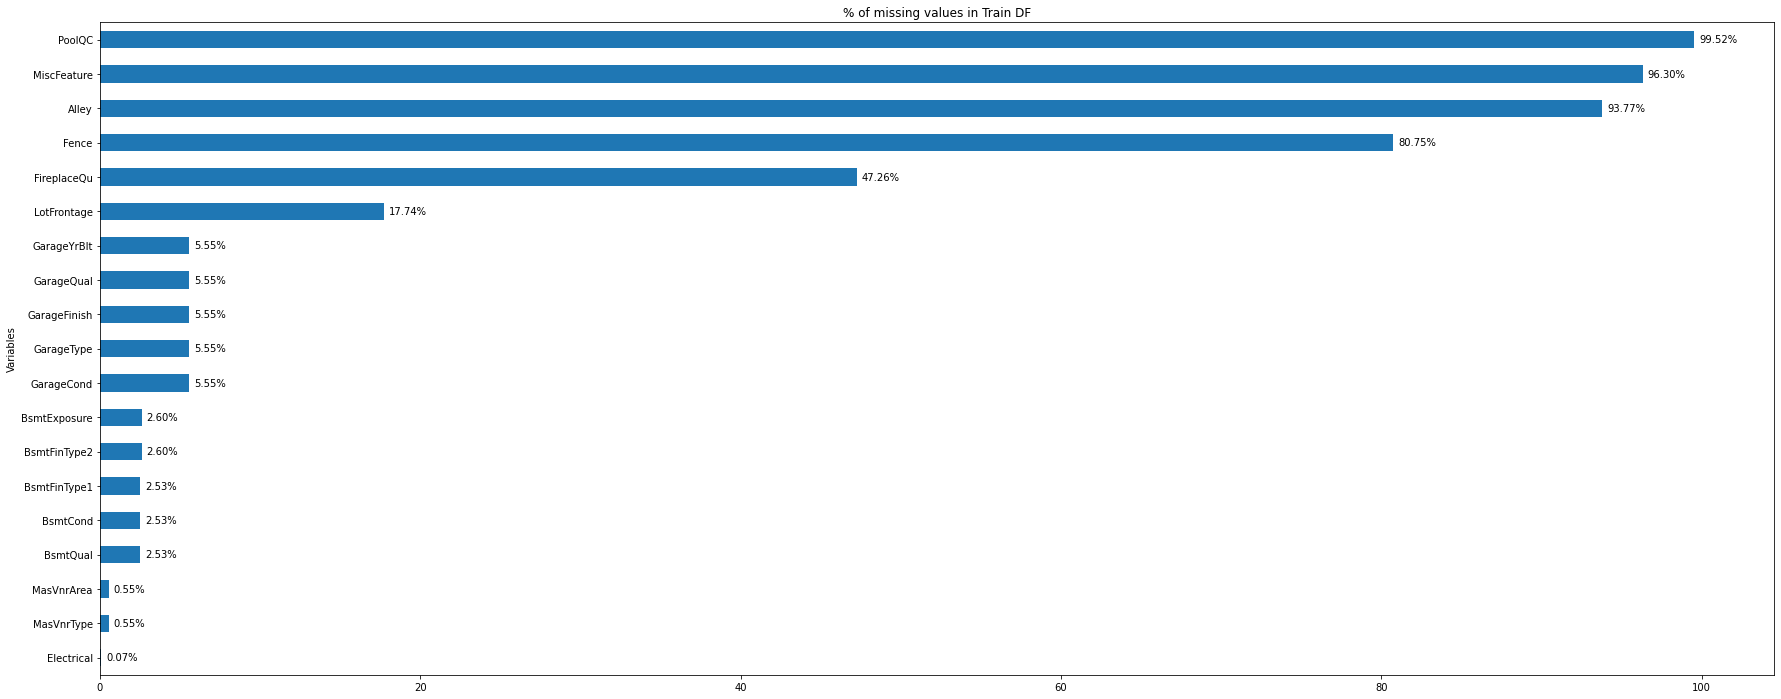

In [6]:
# Let's see the % of NaN values in each column of TRAIN DF (only those ones with missing values)
mask = train_df.isna().mean().sort_values() > 0
ax = (train_df.loc[:, mask[mask == True].keys()].isna().mean().sort_values() * 100).plot(
                                                                                          kind    = 'barh', 
                                                                                          figsize = (30,12),
                                                                                          xlabel  = 'Variables', 
                                                                                          title   = '% of missing values in Train DF'
                                                                                        )

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 5)

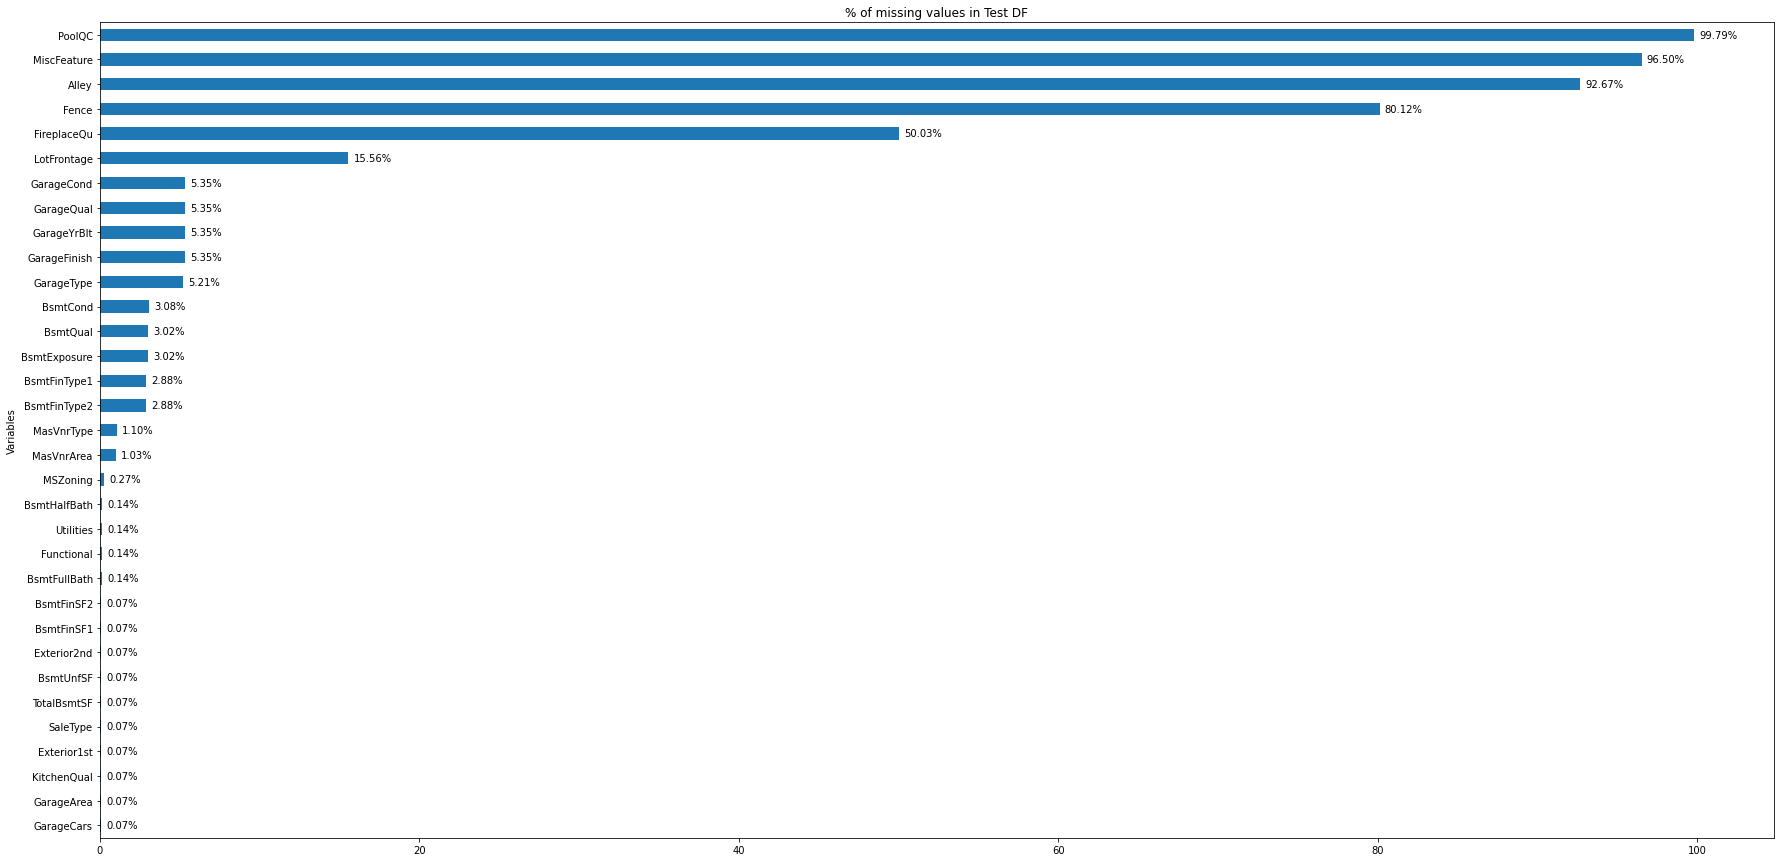

In [7]:
# Let's see the % of NaN values in each column of TEST DF (only those ones with missing values)
mask = test_df.isna().mean().sort_values() > 0
ax = (test_df.loc[:, mask[mask == True].keys()].isna().mean().sort_values() * 100).plot(
                                                                                          kind    = 'barh', 
                                                                                          figsize = (30,15),
                                                                                          xlabel  = 'Variables', 
                                                                                          title   = '% of missing values in Test DF',
                                                                                          grid    = False
                                                                                        )
for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f%%', padding = 5)

In [8]:
# Features almost empty will be removed later
missing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

These are the categorical features with missing values

In [9]:
# Categorical columns with missing values (descending order)
nan_mask = train_df[train_df.columns[train_df.dtypes == object]].isna().sum().sort_values(ascending = False) > 0
train_df.loc[:, nan_mask[nan_mask == True].keys()].dtypes == object

PoolQC          True
MiscFeature     True
Alley           True
Fence           True
FireplaceQu     True
GarageType      True
GarageCond      True
GarageQual      True
GarageFinish    True
BsmtFinType2    True
BsmtExposure    True
BsmtFinType1    True
BsmtQual        True
BsmtCond        True
MasVnrType      True
Electrical      True
dtype: bool

In [10]:
# Let's see data types
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
# See some statistics
train_df.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


#### Numerical features histograms
As we can see below, there are some features that have stepped distributions (YearBuilt, YearRemodAdd, GarageYrBlt, MoSold, YrSold). That's because they really are categorical features instead of numerical.

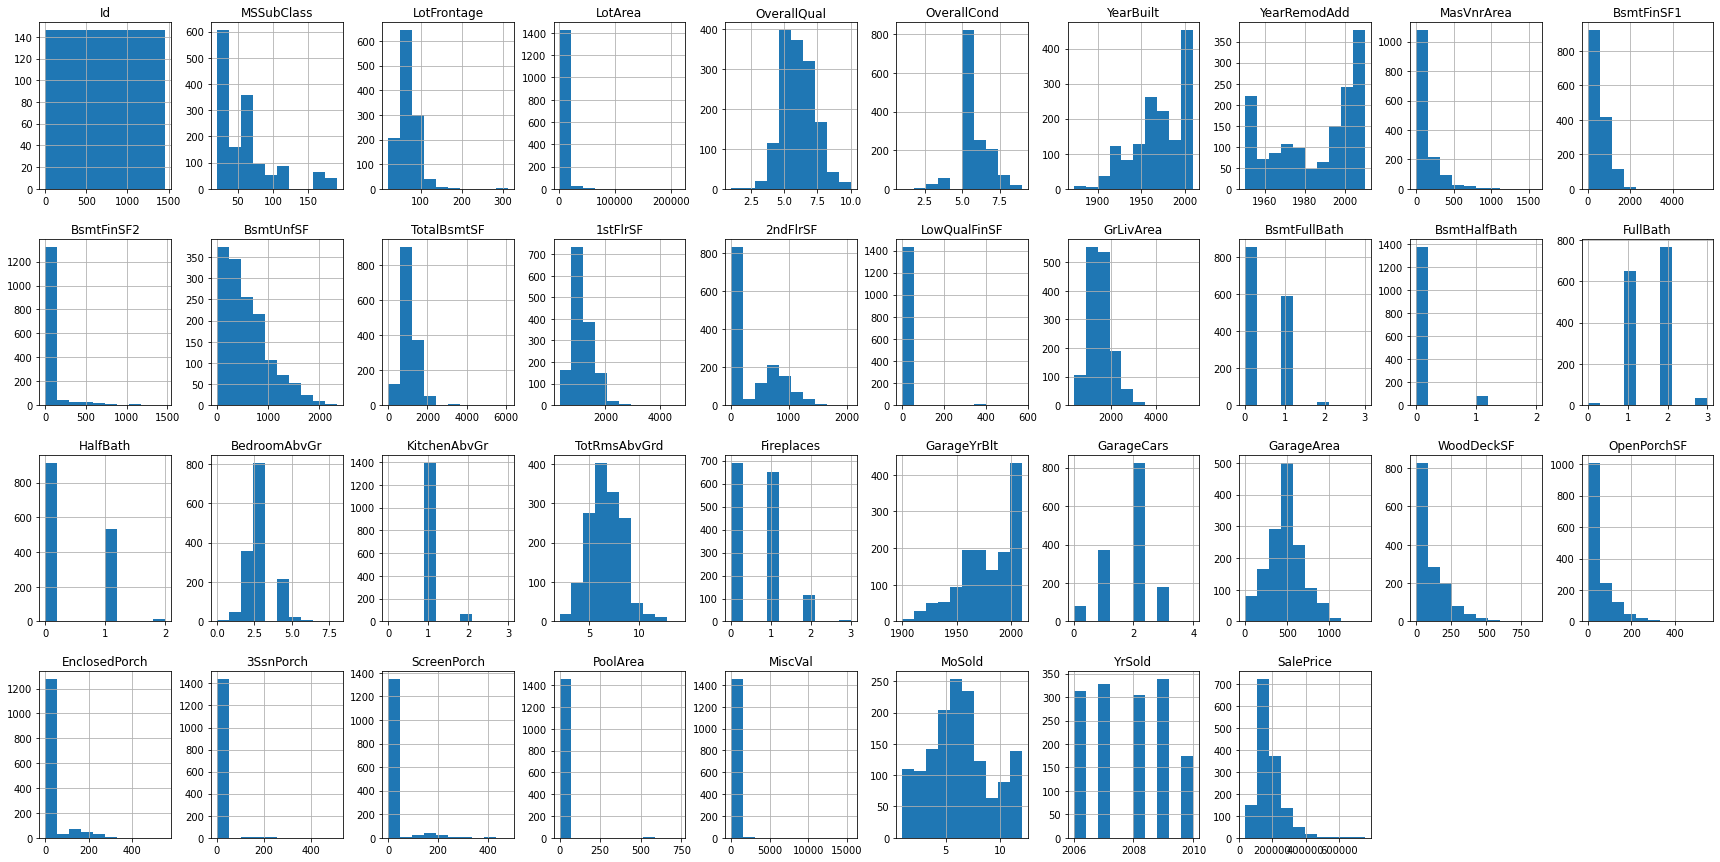

In [12]:
# Filter numerical columns and visualize histograms
num_mask = train_df.dtypes != object
num_cols = train_df.loc[:, num_mask[num_mask == True].keys()]
num_cols.hist(figsize = (30,15), layout = (4,10))
plt.show()

As we can see below, there aren't any numerical features with normal distribution

In [13]:
normality_test(num_cols)

,Feature,Shapiro Statistic,Shapiro p-value,Anderson-Darling Statistic,Anderson-Darling Critical Value (1%)
0,Id,0.869672,3.206248e-33,41.691996,1.089
1,MSSubClass,0.869672,3.206248e-33,41.691996,1.089
2,LotFrontage,0.869672,3.206248e-33,41.691996,1.089
3,LotArea,0.869672,3.206248e-33,41.691996,1.089
4,OverallQual,0.869672,3.206248e-33,41.691996,1.089
5,OverallCond,0.869672,3.206248e-33,41.691996,1.089
6,YearBuilt,0.869672,3.206248e-33,41.691996,1.089
7,YearRemodAdd,0.869672,3.206248e-33,41.691996,1.089
8,MasVnrArea,0.869672,3.206248e-33,41.691996,1.089
9,BsmtFinSF1,0.869672,3.206248e-33,41.691996,1.089


Plot of the skewness degree of each numerical feature

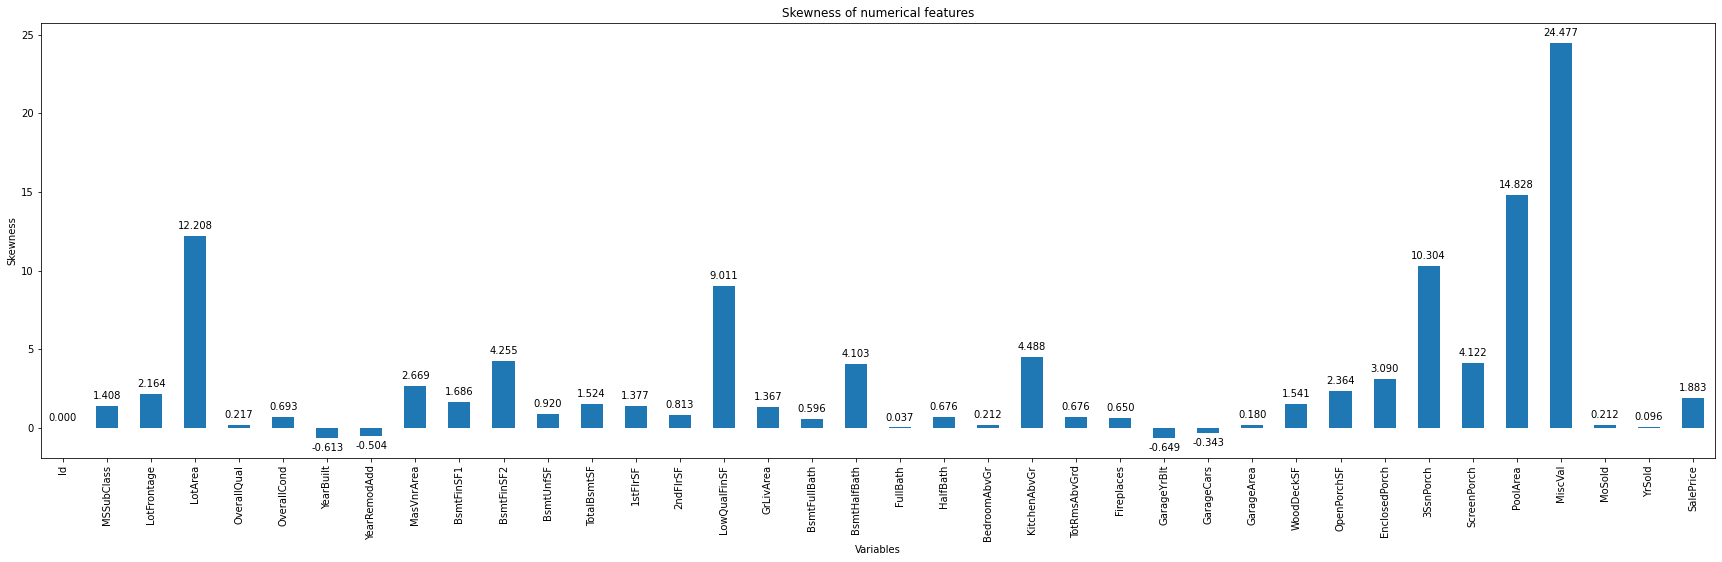

In [14]:
plot_skewness(num_cols, title = 'Skewness of numerical features')

Now, let's take a look at the interquartile ranges of the numerical features, in order to detect potential outliers

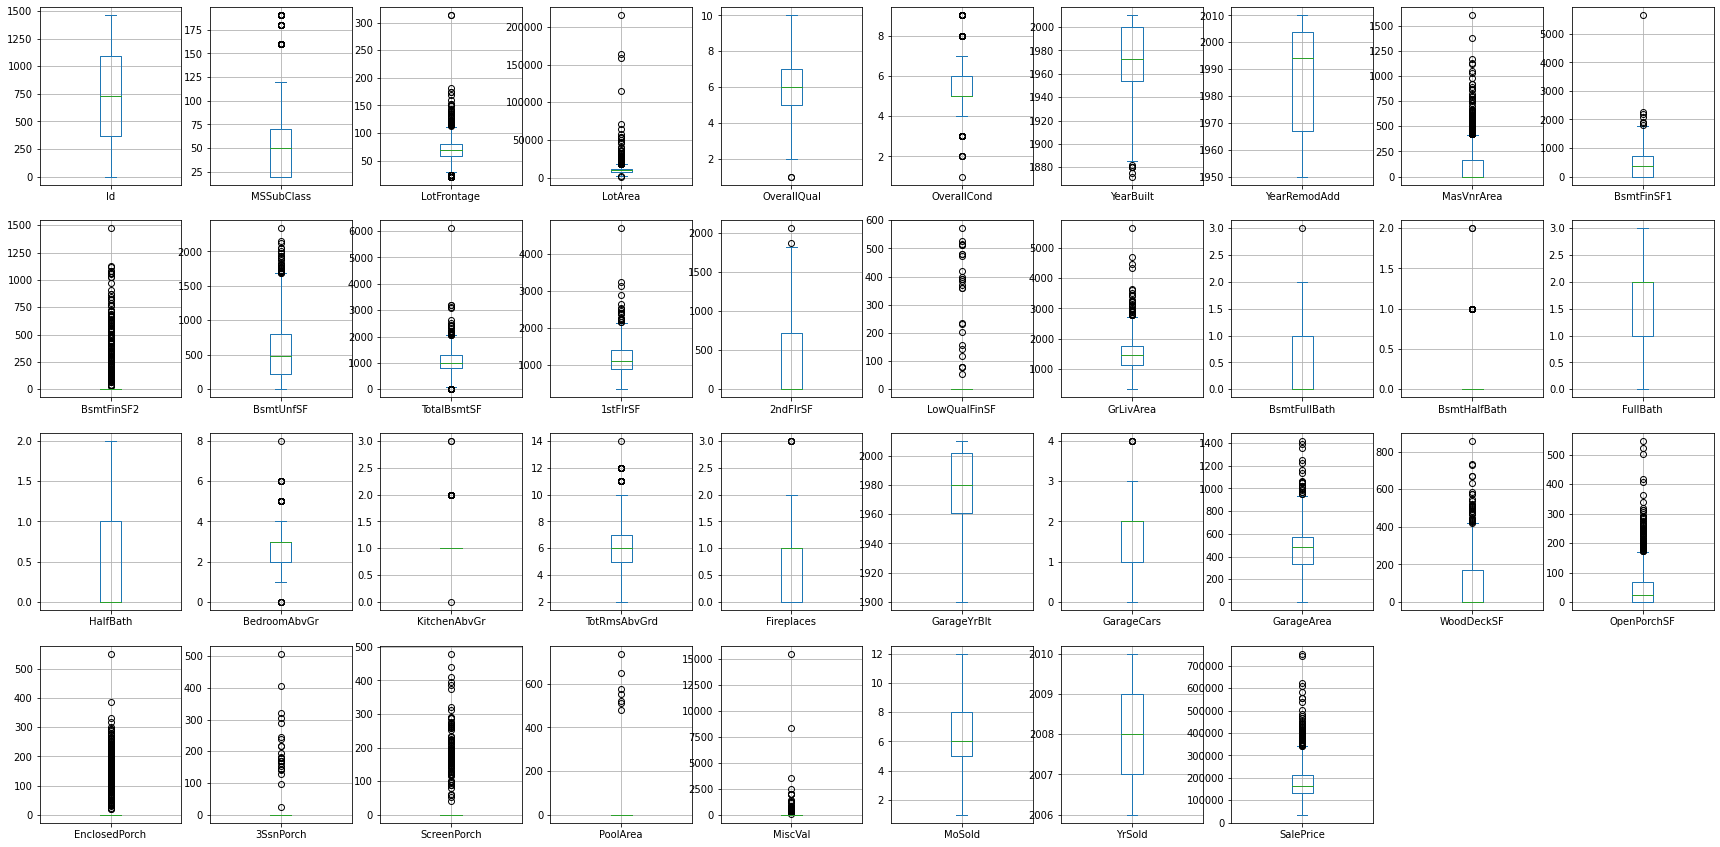

In [15]:
# Let's see the outliers
num_cols.plot(
                kind     = 'box',
                subplots = True, 
                layout   = (4,10), 
                sharex   = False, 
                sharey   = False,
                figsize  = (30,15),
                grid     = True
            )

plt.show()

This is the heatmap of the Pearson's correlation of the numerical variables

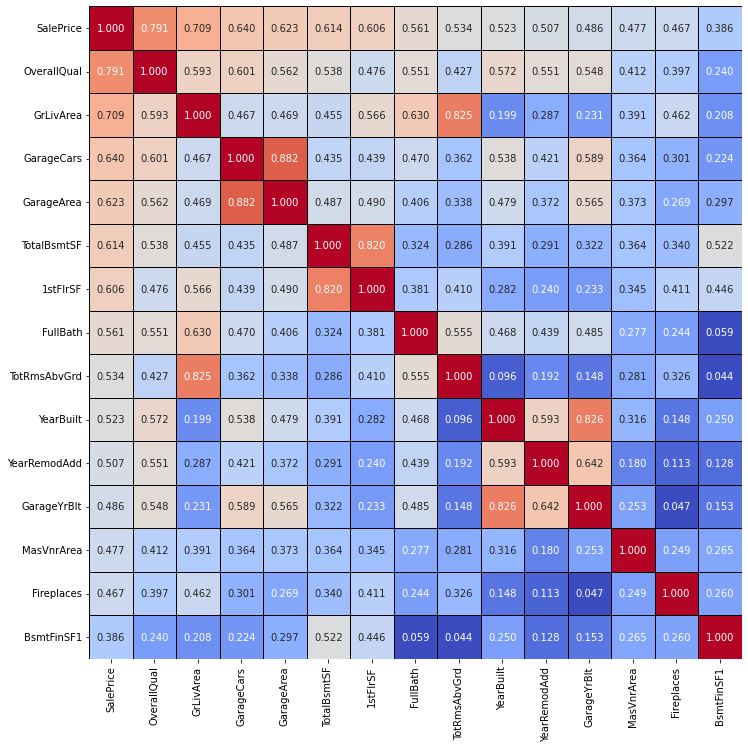

In [16]:
plot_corr_heatmap(num_cols, size = (12,12), n_important = 15)

This is the heatmap of the Spearman's correlation of the numerical variables

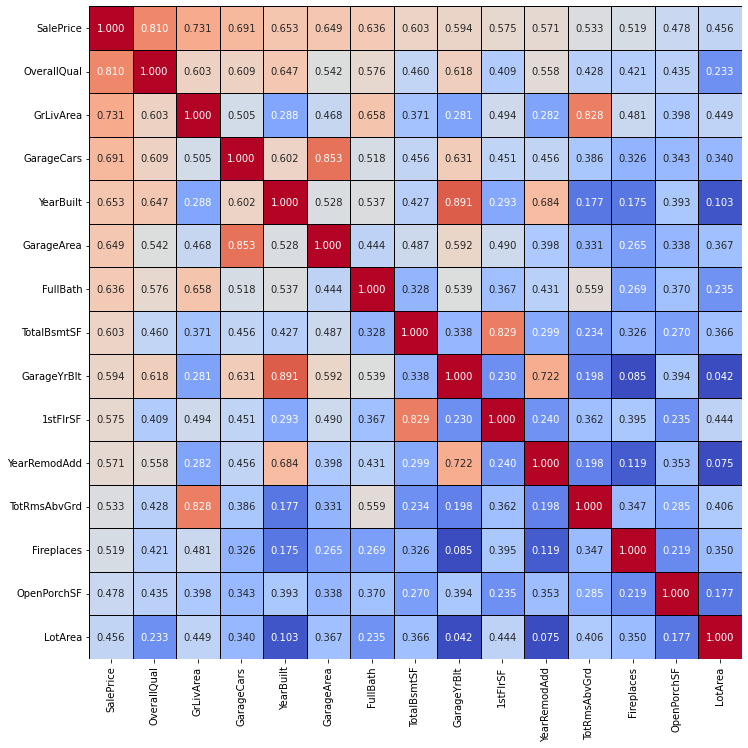

In [17]:
plot_corr_heatmap(num_cols, size = (12,12), mtd = 'spearman', n_important = 15)

Now, let's see some scatterplots of the most important relations

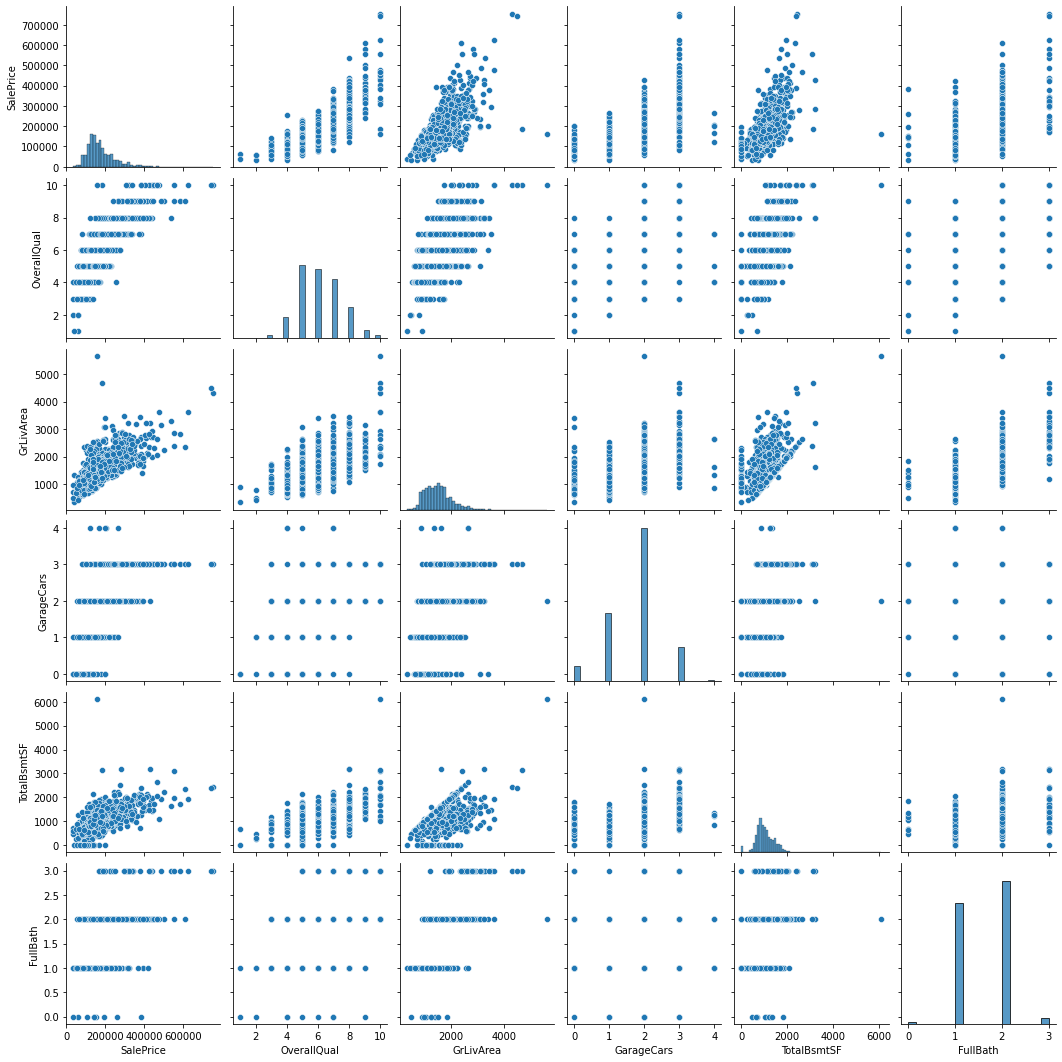

In [18]:
most_corr_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.pairplot(train_df[most_corr_features])

# 3. Separate features from target

In [19]:
# Assignations
X = train_df.drop(columns = ['Id', 'SalePrice'], axis = 1)
y = train_df.loc[:, 'SalePrice'].to_frame()

# 4. Missing data handling, transformations and feature engineering
In this section, we'll manage the missing values and make some transformations in order to get quality data

In [20]:
# As we discussed above, let's assign this variables as categorical
X = X.astype(dtype = {
                        'YrSold'       : object, 
                        'YearBuilt'    : object, 
                        'YearRemodAdd' : object, 
                        'MoSold'       : object, 
                        'GarageYrBlt'  : object
                     }
            )

Now, we search for relationships between some numerical features

In [21]:
# Temporary DF used to seek relations
areas = X.loc[:, [
                    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                    'LowQualFinSF', 'GrLivArea', 'GarageArea', 
                    'OpenPorchSF', 'PoolArea'
                 ]
            ]

<AxesSubplot:ylabel='TotalBsmtSF'>

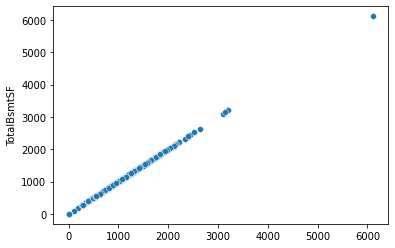

In [22]:
# There is a linear relationship between this features
# 'BsmtFinSF1' + 'BsmtFinSF2' + 'BsmtUnfSF' = 'TotalBsmtSF'
sns.scatterplot(
                    x = np.sum(areas.loc[:, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']], axis = 1),
                    y = areas.loc[:, 'TotalBsmtSF']
                )

In [23]:
# Ensure this by adjusting an OLS model
model = smf.ols("TotalBsmtSF ~ BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF", data = areas).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            TotalBsmtSF   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.669e+32
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:01:04   Log-Likelihood:                 39586.
No. Observations:                1460   AIC:                        -7.916e+04
Df Residuals:                    1456   BIC:                        -7.914e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.187e-13    2.8e-14     18.533      0.0

<AxesSubplot:ylabel='GrLivArea'>

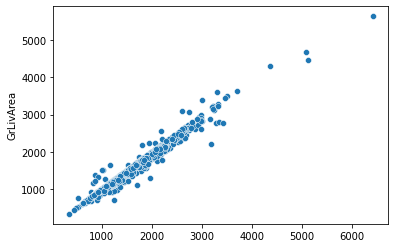

In [24]:
# Same thing with this features. There is a linear relationship too
# 'OpenPorchSF' + '1stFlrSF' + '2ndFlrSF' + 'PoolArea' = 'GrLivArea'
sns.scatterplot(
                    x = np.sum(areas.loc[:, ['OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'PoolArea']], axis = 1),
                    y = areas.loc[:, 'GrLivArea']
                )

In [25]:
# Add a column in order to check linearity later
areas['TotalAreaAbvGr'] = np.sum(areas.loc[:, ['OpenPorchSF', '1stFlrSF', '2ndFlrSF', 'PoolArea']], axis = 1)
areas['TotalAreaAbvGr']

0       1771
1       1262
2       1828
3       1752
4       2282
        ... 
1455    1687
1456    2073
1457    2400
1458    1078
1459    1324
Name: TotalAreaAbvGr, Length: 1460, dtype: int64

In [26]:
# Check linearity
model = smf.ols("GrLivArea ~ TotalAreaAbvGr", data = areas).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              GrLivArea   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 5.578e+04
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:01:04   Log-Likelihood:                -8537.9
No. Observations:                1460   AIC:                         1.708e+04
Df Residuals:                    1458   BIC:                         1.709e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         57.6430      6.552      8.

<AxesSubplot:ylabel='GrLivArea'>

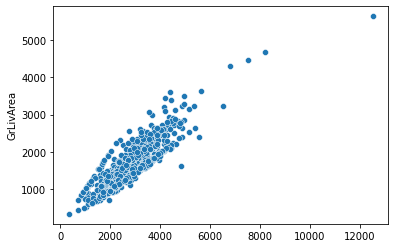

In [27]:
# Now, we check if htere is a relationship between this ones
sns.scatterplot(
                    x = np.sum(areas.loc[:, ['TotalBsmtSF', 'TotalAreaAbvGr']], axis = 1),
                    y = areas.loc[:, 'GrLivArea']
                )

In [28]:
# It seems like there is
model = smf.ols("GrLivArea ~ TotalAreaAbvGr + TotalBsmtSF", data = areas).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              GrLivArea   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 2.806e+04
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        18:01:05   Log-Likelihood:                -8533.0
No. Observations:                1460   AIC:                         1.707e+04
Df Residuals:                    1457   BIC:                         1.709e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         66.0724      7.064      9.

Now, let's treat the outliers

In [29]:
# Filter the numerical data with the most relevant features
numerical_features = X[most_corr_features[1:]]
numerical_features

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath
0,7,1710,2,856,2
1,6,1262,2,1262,2
2,7,1786,2,920,2
3,7,1717,3,756,1
4,8,2198,3,1145,2
...,...,...,...,...,...
1455,6,1647,2,953,2
1456,6,2073,2,1542,2
1457,7,2340,1,1152,2
1458,5,1078,1,1078,1


In [30]:
# Filter the categorical features
categorical_features = X.select_dtypes(include = [object])
categorical_features

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,TA,Y,NaN,NaN,NaN,2,2008,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,TA,Y,NaN,NaN,NaN,5,2007,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,TA,TA,Y,NaN,NaN,NaN,9,2008,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,TA,TA,Y,NaN,NaN,NaN,2,2006,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,TA,TA,Y,NaN,NaN,NaN,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,TA,Y,NaN,NaN,NaN,8,2007,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,TA,TA,Y,NaN,MnPrv,NaN,2,2010,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,TA,TA,Y,NaN,GdPrv,Shed,5,2010,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,TA,TA,Y,NaN,NaN,NaN,4,2010,WD,Normal


In [31]:
# Modify this variable, leaving only the relevant features
X = X.loc[:, list(categorical_features.columns) + list(numerical_features.columns)]

# Drop almost empty columns
X.drop(columns = missing, inplace = True)

# See the result
X

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Y,2,2008,WD,Normal,7,1710,2,856,2
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Y,5,2007,WD,Normal,6,1262,2,1262,2
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Y,9,2008,WD,Normal,7,1786,2,920,2
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Y,2,2006,WD,Abnorml,7,1717,3,756,1
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Y,12,2008,WD,Normal,8,2198,3,1145,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,8,2007,WD,Normal,6,1647,2,953,2
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,Y,2,2010,WD,Normal,6,2073,2,1542,2
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Y,5,2010,WD,Normal,7,2340,1,1152,2
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Y,4,2010,WD,Normal,5,1078,1,1078,1


In [32]:
# First, detect the outliers with IsolationForest
iforest = IsolationForest(
                            n_estimators  = 100,
                            max_samples   = 1.0,
                            contamination = 0.01, 
                            bootstrap     = True,
                            n_jobs        = -1, 
                            random_state  = rand_seed,
                            warm_start    = True
                        )

# Add an indicator column in the new data
X['outliers'] = iforest.fit_predict(X[numerical_features.columns])

In [33]:
# See the detected outliers
X[X['outliers'] == -1].select_dtypes(exclude = [object])

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,outliers
53,9,1842,3,1842,0,-1
375,1,904,0,683,0,-1
496,8,3228,2,3200,3,-1
523,10,4676,3,3138,3,-1
533,1,334,0,0,1,-1
635,6,3395,0,1440,2,-1
691,10,4316,3,2444,3,-1
738,5,1200,0,1200,3,-1
747,7,2640,4,1240,1,-1
916,2,480,1,480,0,-1


Let's see the ouliers detected by IsolationForest

In [34]:
# Get the outliers indexes
outliers_index = X[X['outliers'] == -1].index

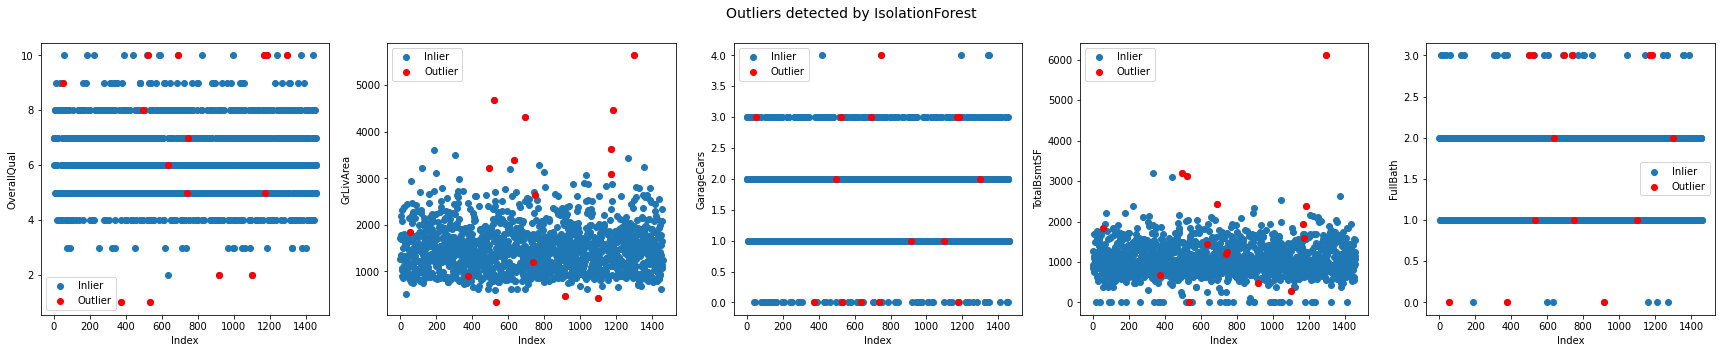

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = numerical_features.shape[1], sharex = True, sharey = False, figsize = (30, 5))

fig.suptitle(t = 'Outliers detected by IsolationForest', fontsize = 14)

for i, col in enumerate(numerical_features):
    ax[i].set_xlabel('Index')
    ax[i].set_ylabel(col)
    ax[i].set_label('Outlier')
    ax[i].scatter(x = numerical_features.index, y = numerical_features[col], label = 'Inlier')
    ax[i].scatter(x = outliers_index, y = numerical_features[col][outliers_index], c = 'red', label = 'Outlier')
    ax[i].legend()

plt.show()

In [36]:
# Filter the outliers
X = X[X['outliers'] == 1].iloc[:, :-1]
X

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Y,2,2008,WD,Normal,7,1710,2,856,2
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Y,5,2007,WD,Normal,6,1262,2,1262,2
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Y,9,2008,WD,Normal,7,1786,2,920,2
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Y,2,2006,WD,Abnorml,7,1717,3,756,1
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Y,12,2008,WD,Normal,8,2198,3,1145,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,8,2007,WD,Normal,6,1647,2,953,2
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,Y,2,2010,WD,Normal,6,2073,2,1542,2
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Y,5,2010,WD,Normal,7,2340,1,1152,2
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Y,4,2010,WD,Normal,5,1078,1,1078,1


This is one of the most important parts of the notebook. In this lines, we build the pipeline used to transform data.

In [37]:
# Get categorical columns names
categ_cols_names = X.columns[X.dtypes == object]

# Categorical columns with missing values
categ_nan_cols = X[categ_cols_names].columns[X[categ_cols_names].isna().sum() > 0]

# Get numerical columns names
num_cols_names = X.columns[X.dtypes != object]

# Numerical columns with missing values
num_nan_cols = X[num_cols_names].columns[X[num_cols_names].isna().sum() > 0]

In [38]:
# Assign np.nan type to NaN values in categorical features
# in order to ensure detectability in posterior methods
X[categ_nan_cols] = X[categ_nan_cols].fillna(value = np.nan, axis = 1)

# Same thing in numerical features
X[num_nan_cols] = X[num_nan_cols].fillna(value = np.nan, axis = 1)

In [39]:
# Define pipeline for imputation of the numerical features
num_pipeline = Pipeline(steps = [
                                    ('Simple Imputer', SimpleImputer(strategy = 'median')),
                                    ('Robust Scaler', RobustScaler()),
                                    ('Power Transformer', PowerTransformer())
                                ]
                        )

# Define pipeline for imputation and encoding of the categorical features
categ_pipeline = Pipeline(
                            steps = [
                                        ('Categorical Imputer', SimpleImputer(strategy = 'most_frequent')),
                                        ('One Hot Encoder', OneHotEncoder(drop = 'first'))
                                    ]
                         )

# Transform specific columns
ct = ColumnTransformer(
                        [
                            ('Categorical Pipeline', categ_pipeline, categ_cols_names),
                            ('Numerical Pipeline', num_pipeline, num_cols_names)
                        ], 
                        remainder        = 'passthrough', 
                        sparse_threshold = 0,
                        n_jobs           = -1
                    )

# Final pipeline with all transformations
pipe = Pipeline(steps = [
                            ('Column Transformer', ct), 
                            ('PCA', PCA(n_components = 286, whiten = False, svd_solver = 'full', random_state = rand_seed)),
                        ]
               )

In [40]:
# Let's visualize and check the pipeline
pipe

Pipeline(steps=[('Column Transformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   sparse_threshold=0,
                                   transformers=[('Categorical Pipeline',
                                                  Pipeline(steps=[('Categorical '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('One Hot '
                                                                   'Encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig...
       'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')),
                                                 ('Numerical Pipeline',
                                                  Pipeline(steps=[('Simple '
                                                                   'Imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Robust '
                                                                   'Scaler',
                                                                   RobustScaler()),
                                                                  ('Power '
                                                                   'Transformer',
                                                                   PowerTransformer())]),
                                                  Index(['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath'], dtype='object'))])),
                ('PCA',
                 PCA(n_components=286, random_state=123, svd_solver='full'))])

In [41]:
# Create a new DF with the transformed data
Xt = pd.DataFrame(data = pipe.fit_transform(X))
Xt

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,2.058876,1.037804,-0.970987,-1.125847,0.323205,-0.585442,-0.434996,-0.064657,-1.022497,0.280457,...,0.015502,0.038591,-0.003870,-0.031126,-0.006297,0.008456,0.008271,0.003974,-0.005068,0.004378
1,0.133670,-0.816262,0.306670,-0.518355,0.085685,0.804721,0.682131,1.135981,0.362053,-0.052500,...,-0.000505,-0.045442,-0.014847,-0.015283,-0.010395,0.072666,0.035172,-0.083201,-0.007537,-0.023886
2,2.278603,0.794834,-0.857409,-1.213247,0.258187,-0.628200,0.133577,-0.181250,-0.542056,0.294490,...,-0.016379,0.037233,0.005007,0.014546,0.048333,0.015444,0.007933,0.015565,-0.001558,-0.001709
3,0.179521,0.771728,0.766192,1.555191,1.431272,-0.834282,0.944803,-0.935299,0.670715,-0.775221,...,0.017164,0.037276,-0.011715,-0.039481,0.010624,-0.042509,0.054874,0.010117,0.010234,-0.097482
4,3.499641,0.495757,-0.096552,-0.485263,1.090622,-0.711694,0.484100,-0.389236,-0.386728,0.182333,...,-0.036111,0.016398,-0.011832,0.006989,-0.023578,0.004145,0.014852,0.011566,0.010388,-0.008003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.877596,1.224939,-0.199769,-0.511209,0.031794,0.887673,0.003623,-0.421036,-0.092123,0.863002,...,0.012673,-0.029967,0.026753,0.010738,-0.012761,-0.003863,0.007529,-0.042057,0.005550,-0.001433
1441,0.663255,-0.958421,1.795382,-0.587990,-0.412042,0.910872,0.483812,0.759267,-0.125432,0.903562,...,-0.057216,-0.045694,-0.034739,0.002094,-0.156768,0.064112,0.004496,0.024227,0.095240,0.075697
1442,1.055017,0.826395,0.897621,-0.804220,-1.640724,-0.868052,0.027991,0.000987,0.020381,-0.462850,...,0.199139,-0.007927,-0.000741,0.049053,0.061644,0.024072,0.021888,-0.129390,0.162488,-0.057391
1443,-1.868981,-1.357772,-0.271481,-0.062087,-0.630384,-0.621314,0.028718,0.261390,-0.399261,-0.972063,...,-0.056882,0.015783,-0.014110,-0.028361,-0.009794,0.040965,-0.043089,0.018577,-0.014334,0.062475


In [42]:
# Let's see some statistics of the new data
Xt.describe()

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
count,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,...,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03,1.445000e+03
mean,1.275412e-17,3.380610e-18,-8.890908e-18,-4.471625e-17,1.767137e-17,-1.171689e-17,-3.369085e-17,2.746746e-17,-2.956113e-17,1.356086e-17,...,4.351815e-19,5.118935e-18,6.165771e-18,-4.381827e-18,9.894527e-18,3.920835e-18,4.235967e-18,-2.648304e-18,3.066229e-18,-6.254609e-18
std,2.078589e+00,1.084433e+00,9.818965e-01,7.954719e-01,7.338990e-01,6.868340e-01,6.374623e-01,6.154974e-01,5.881335e-01,5.619213e-01,...,5.673126e-02,5.638869e-02,5.618123e-02,5.605333e-02,5.524039e-02,5.502378e-02,5.470949e-02,5.446576e-02,5.436046e-02,5.418675e-02
min,-4.463431e+00,-2.931186e+00,-3.075974e+00,-2.070685e+00,-2.732285e+00,-2.243724e+00,-1.898711e+00,-1.720125e+00,-1.529245e+00,-1.847226e+00,...,-2.371521e-01,-2.458000e-01,-3.900007e-01,-3.489335e-01,-2.719420e-01,-2.268421e-01,-2.526244e-01,-2.148029e-01,-2.618524e-01,-2.457554e-01
25%,-1.837877e+00,-8.445992e-01,-6.726165e-01,-5.945238e-01,-4.621328e-01,-4.483142e-01,-4.056092e-01,-4.260808e-01,-4.140160e-01,-3.724435e-01,...,-2.741346e-02,-2.683013e-02,-2.318111e-02,-2.229628e-02,-2.673480e-02,-2.712820e-02,-2.435068e-02,-2.696119e-02,-2.740370e-02,-2.495828e-02
50%,-2.747367e-01,-1.518669e-01,-3.176133e-02,-1.008649e-01,-3.267681e-03,-2.796978e-02,2.002288e-02,-3.771042e-02,-4.097947e-02,-2.695355e-04,...,1.090719e-03,9.339165e-04,-1.159958e-05,-1.176270e-03,-1.456936e-03,-3.276138e-04,2.337601e-04,1.839365e-03,7.224429e-04,-1.431066e-03
75%,1.827315e+00,8.761820e-01,6.498320e-01,5.790793e-01,4.835167e-01,4.260494e-01,4.030117e-01,3.688009e-01,3.833728e-01,3.693027e-01,...,2.585445e-02,2.481591e-02,2.232035e-02,2.191137e-02,2.255822e-02,2.503417e-02,2.401944e-02,2.831781e-02,2.484954e-02,2.268637e-02
max,5.127472e+00,3.136984e+00,3.173339e+00,2.389047e+00,3.293485e+00,2.345389e+00,2.038372e+00,2.048500e+00,1.804573e+00,1.900668e+00,...,2.862689e-01,2.865875e-01,4.624491e-01,3.511183e-01,3.118243e-01,3.005650e-01,3.368570e-01,3.784319e-01,2.643476e-01,3.664708e-01


Now, features are more Gaussian-like

In [43]:
normality_test(Xt)

,Feature,Shapiro Statistic,Shapiro p-value,Anderson-Darling Statistic,Anderson-Darling Critical Value (1%)
0,0,0.932152,4.235537e-25,23.868446,1.089
1,1,0.932152,4.235537e-25,23.868446,1.089
2,2,0.932152,4.235537e-25,23.868446,1.089
3,3,0.932152,4.235537e-25,23.868446,1.089
4,4,0.932152,4.235537e-25,23.868446,1.089
...,...,...,...,...,...
281,281,0.932152,4.235537e-25,23.868446,1.089
282,282,0.932152,4.235537e-25,23.868446,1.089
283,283,0.932152,4.235537e-25,23.868446,1.089
284,284,0.932152,4.235537e-25,23.868446,1.089


/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


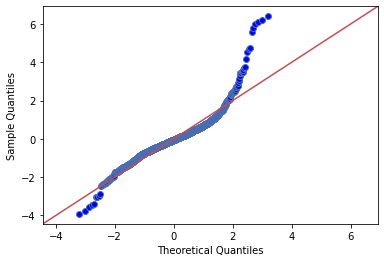

In [44]:
# Let's see the worst case
qqplot(Xt[Xt.skew().abs().idxmax()], fit = True, line = '45')
plt.show()

Let's plot again the skewness of each feature, in order to check the transformations made

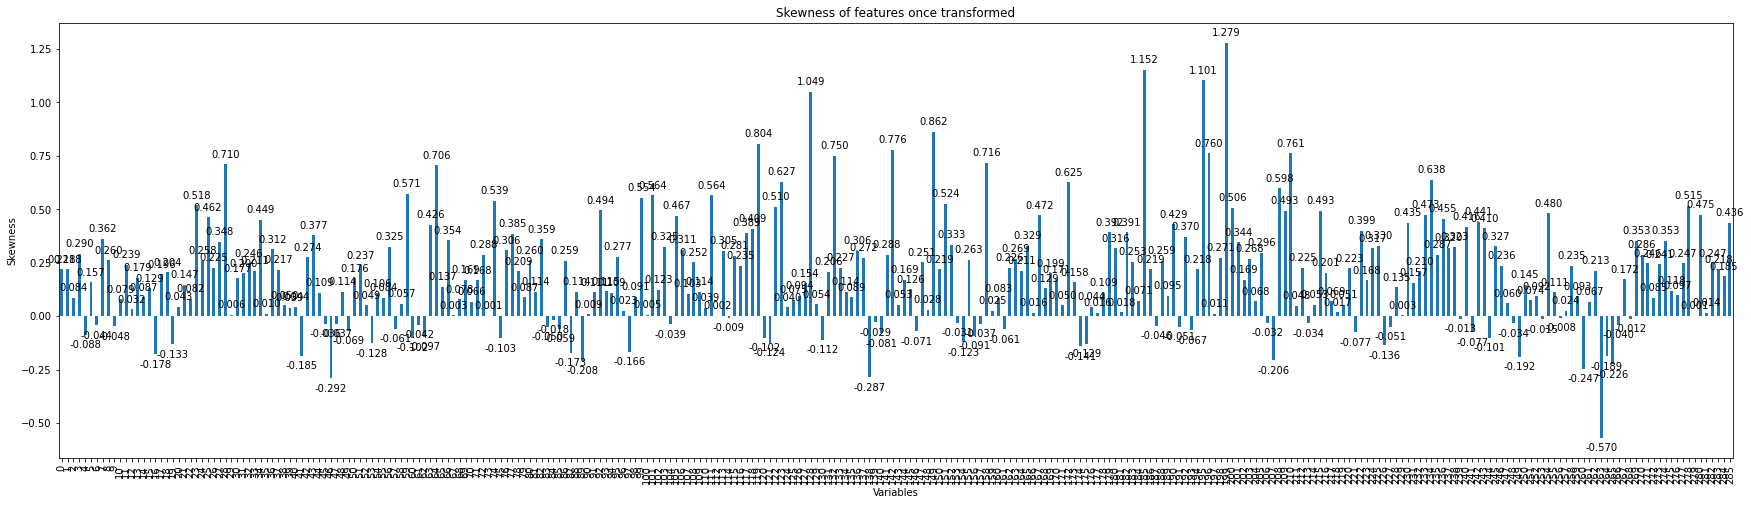

In [45]:
plot_skewness(Xt, title = 'Skewness of features once transformed')

Now, we can plot again the histograms to compare it

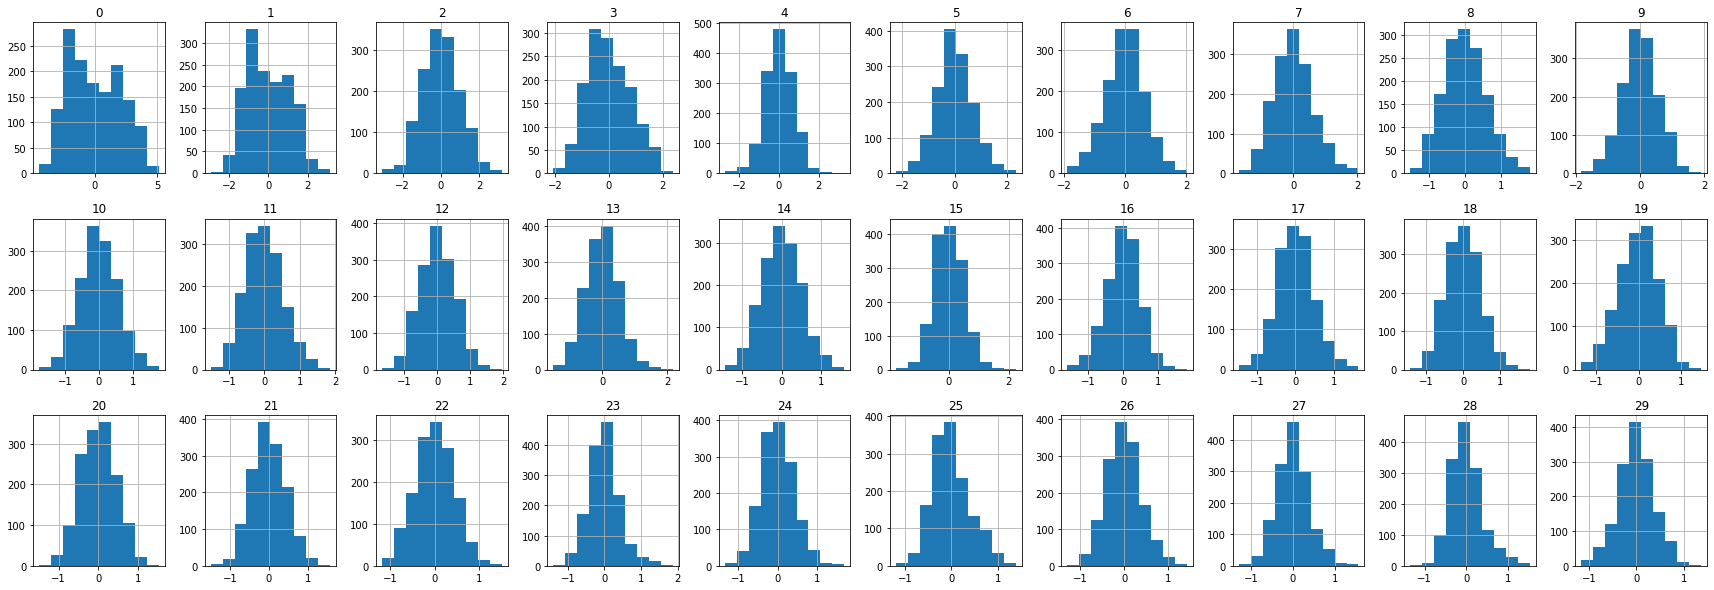

In [46]:
Xt.iloc[:, :30].hist(figsize = (30,10), layout = (3,10))
plt.show()

In [47]:
# No missing values left
print('Missing values = ' + str(Xt.isna().sum().sum()))

Missing values = 0


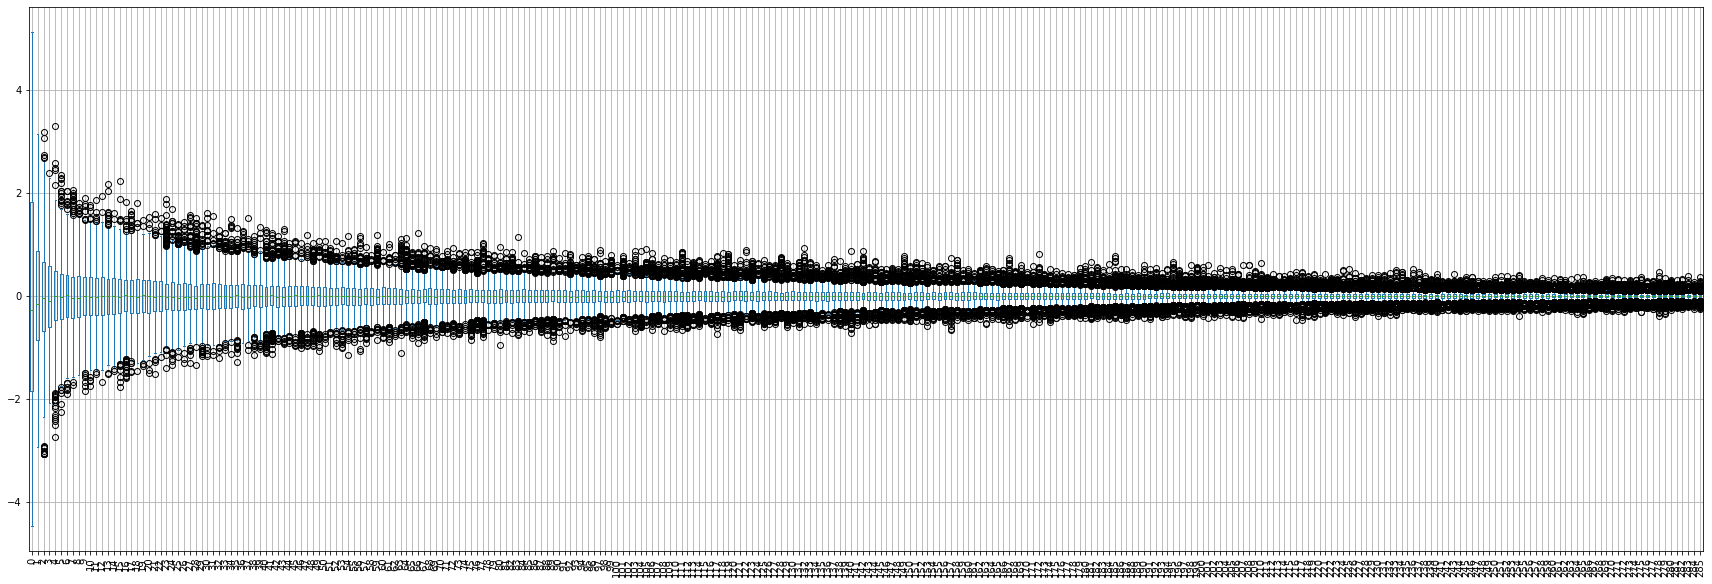

In [48]:
# Let's see the outliers
Xt.plot(kind = 'box', figsize = (30,10), grid = True, rot = 90)
plt.show()

<AxesSubplot:ylabel='285'>

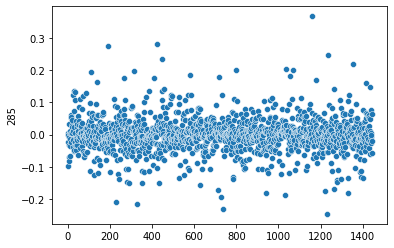

In [49]:
# See the last case
sns.scatterplot(x = Xt.index, y = Xt.iloc[:, -1])

Now, try to fix the skewness of some features

In [50]:
# Filter the most skewed features
skew_mask = Xt.skew().abs() > 0.3
skewed = Xt.loc[:, skew_mask[skew_mask == True].keys()]
skewed

,7,23,25,27,28,34,36,43,56,59,...,242,243,245,254,263,269,274,278,280,285
0,-0.064657,0.359270,-0.160157,0.078765,0.174495,0.048198,-0.270907,0.122319,-0.017942,0.135968,...,0.009287,0.026808,0.005536,-0.013868,-0.008733,0.014317,0.020284,-0.003870,-0.006297,0.004378
1,1.135981,-0.349608,-0.215734,0.237221,1.197220,0.359523,-0.339153,0.133276,0.293841,0.844962,...,-0.021267,-0.088321,0.060901,-0.032087,0.009517,0.045147,-0.019177,-0.014847,-0.010395,-0.023886
2,-0.181250,0.248643,-0.014474,-0.093662,0.178010,0.014332,-0.425280,-0.358751,0.345231,-0.249717,...,-0.005478,-0.029663,0.006292,-0.012722,0.001463,-0.016704,-0.001137,0.005007,0.048333,-0.001709
3,-0.935299,-0.025992,-0.451625,0.271385,-0.524340,0.192312,0.061019,0.108654,-0.032468,-0.056454,...,-0.104622,0.056077,-0.007066,0.092752,0.036504,-0.054424,-0.000520,-0.011715,0.010624,-0.097482
4,-0.389236,-0.001902,-0.294453,-0.167713,0.185364,-0.091700,-0.015766,-0.372394,0.752024,0.272485,...,0.007463,0.033396,0.005555,-0.023677,-0.015819,0.009571,-0.002316,-0.011832,-0.023578,-0.008003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,-0.421036,0.228004,-0.093520,0.008747,0.094181,-0.279125,0.182239,0.007250,0.332462,0.206487,...,-0.085781,-0.063119,-0.022159,-0.005538,0.005906,0.007239,0.009807,0.026753,-0.012761,-0.001433
1441,0.759267,-0.152887,0.401205,0.042769,-0.233624,0.362754,0.950759,-0.060933,0.047199,0.346196,...,0.219932,-0.023200,-0.087784,-0.022056,0.039674,-0.000324,0.181116,-0.034739,-0.156768,0.075697
1442,0.000987,1.001572,-0.921941,0.262778,-0.529928,0.800377,-0.373766,-0.263729,-0.022392,-0.106157,...,0.045779,0.107922,-0.027248,0.067613,0.037895,-0.017979,-0.003658,-0.000741,0.061644,-0.057391
1443,0.261390,-0.814346,0.262839,0.006904,-0.163761,-0.210945,0.661116,-0.005531,0.280048,-0.109530,...,0.012396,0.002674,0.116788,-0.009628,0.039085,0.048989,-0.070700,-0.014110,-0.009794,0.062475


In [51]:
# Transform the skewed features in order they look more Gaussian-like
for col in skewed:
    #Xt[col] = stats.yeojohnson(x = skewed[col], lmbda = None)[0]
    Xt[col] = stats.yeojohnson(x = skewed[col], lmbda = stats.yeojohnson_normmax(skewed[col]))

Finally, plot again the skewness graph of the worst case

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


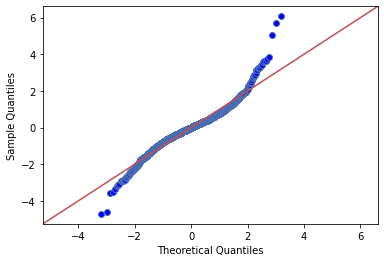

In [52]:
qqplot(Xt[Xt.skew().abs().idxmax()], fit = True, line = '45')
plt.show()

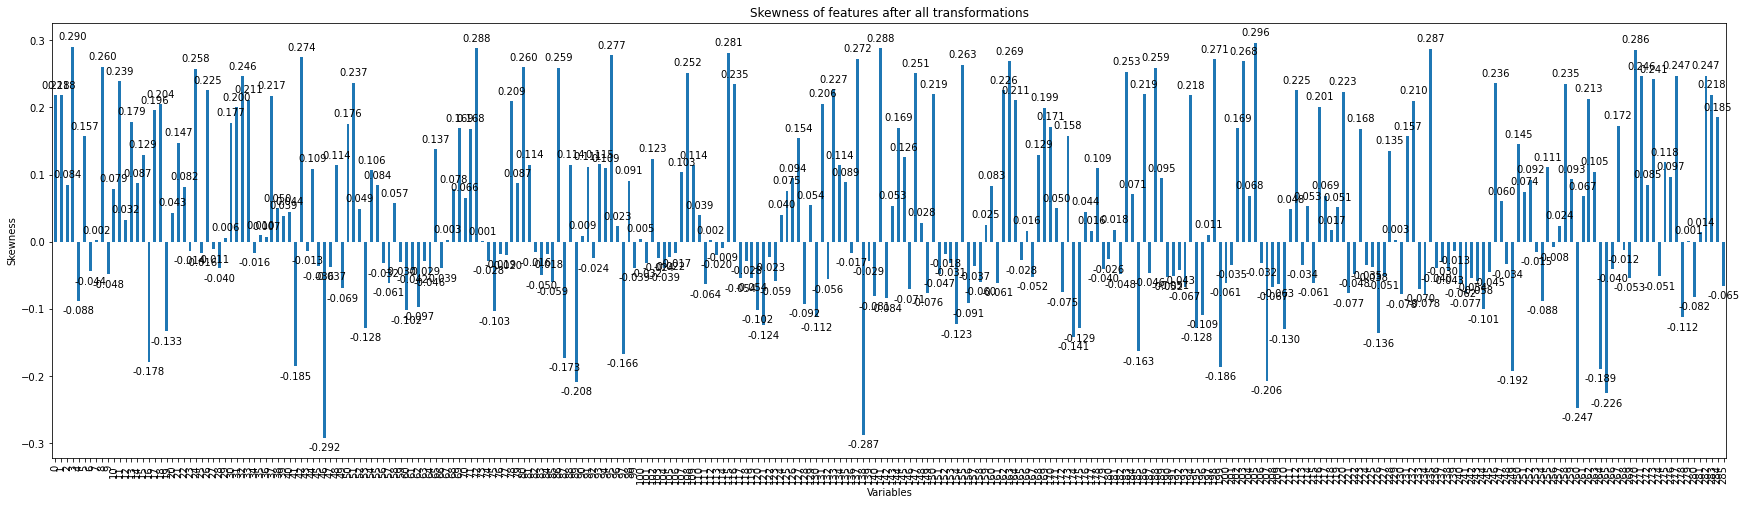

In [53]:
plot_skewness(Xt, title = 'Skewness of features after all transformations')

After the transformations, one of the worst cases left it's pretty Gaussian-like

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='205'>

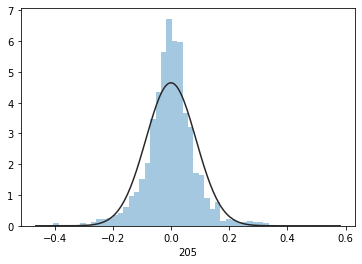

In [54]:
sns.distplot(Xt[Xt.skew().abs().idxmax()], kde = False, fit = stats.norm)

Now, les treat the target variable.

In [55]:
# Filter the same indexes in the target variable
y_ol = y.drop(labels = outliers_index)
y_ol

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


In [56]:
# Aplly a log transform in order to reduce skewness. After modeling, we need to do inverse transform to get real results.
y_ol = pd.DataFrame(data = np.log(y_ol), columns = ['SalePrice'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

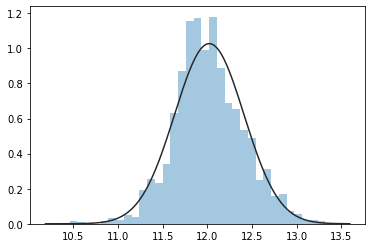

In [57]:
sns.distplot(y_ol, kde = False, fit = stats.norm)

In [58]:
# The target variable now has a very little skewness
y_ol.skew()

SalePrice    0.12262
dtype: float64

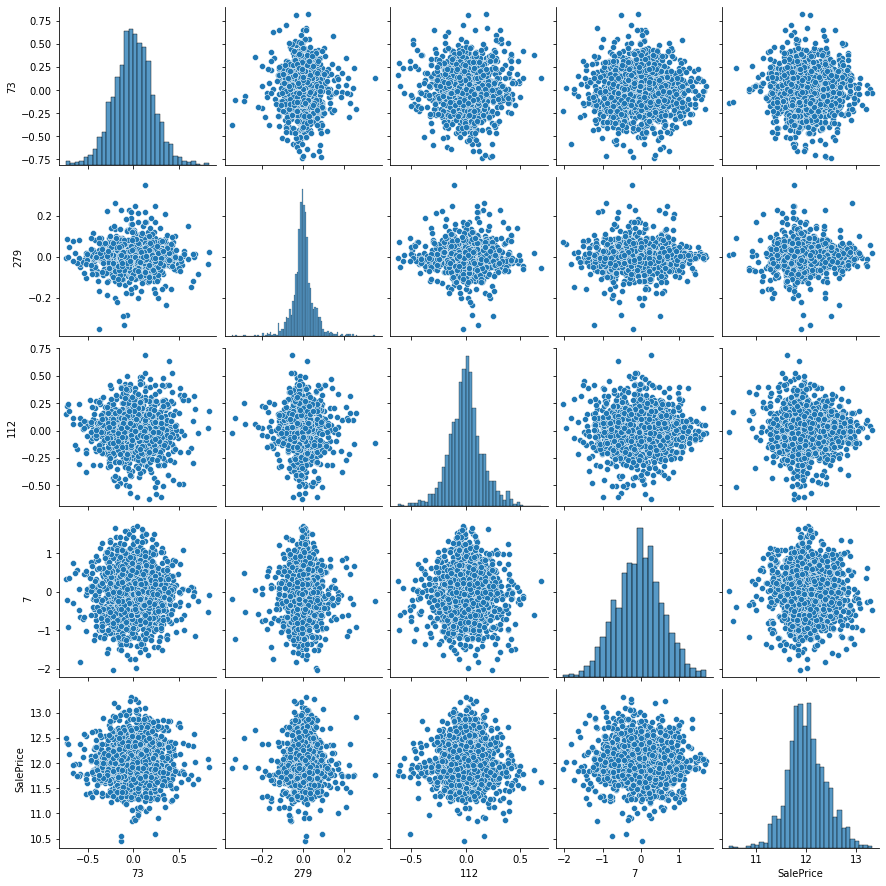

In [59]:
# Let's pairplot against 4 less skewed variables
plot_df = Xt.iloc[:, Xt.skew().abs().sort_values()[:4].index]
plot_df.insert(loc = plot_df.shape[1], column = 'SalePrice', value = y_ol.values)
sns.pairplot(plot_df)

# 5. Machine Learning model for predictions
In this section we'll use a Stacking of XGBoost, LGBM and SGD regressors. Also we perform a cross validation check.

In [60]:
# Assing train variables
X_train = Xt
y_train = y_ol

In [61]:
# Folds for cross-validation
cv_folds = 5

In [62]:
# Tunning
rs = RandomizedSearchCV(
                            estimator = XGBRegressor(
                                                        objective   = 'reg:squarederror',
                                                        eval_metric = 'rmse',
                                                        booster     = "gbtree",
                                                        base_score  = 0.5,
                                                        tree_method = 'gpu_hist',
                                                        n_jobs      = -1
                                                    ),
                            param_distributions = {
                                                    'n_estimators'     : [10, 100, 650, 1000, 2000, 3500],
                                                    'max_depth'        : [2, 4, 6, 8, 10, 12],
                                                    'learning_rate'    : np.random.random(size = 10),
                                                    'reg_lambda'       : np.random.uniform(0, 10, size = 5),
                                                    'reg_alpha'        : np.random.uniform(0, 10, size = 5),
                                                    'min_child_weight' : np.random.uniform(0, 10, size = 5),
                                                    'max_delta_step'   : np.random.uniform(0, 10, size = 5),
                                                    'subsample'        : [0.1, 0.25, 0.5, 0.75, 1],
                                                    'tree_method'      : ['gpu_hist']
                                                  },
                            n_iter             = 100,
                            scoring            = 'neg_root_mean_squared_error',
                            n_jobs             = -1,
                            cv                 = cv_folds,
                            return_train_score = True,
                            random_state       = rand_seed
                        )

res = rs.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [63]:
cv_res = pd.DataFrame(res.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tree_method,param_subsample,param_reg_lambda,param_reg_alpha,param_n_estimators,param_min_child_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,9.373982,1.679068,0.039066,0.007879,gpu_hist,0.1,7.913483,3.435267,1000,3.015441,...,-44.262654,22.447485,100,-17.107747,-0.140480,-16.069944,-17.531188,-17.738658,-13.717603,6.812887
1,2.039562,0.490833,0.027000,0.007297,gpu_hist,1,0.586131,3.213822,650,8.683064,...,-0.173219,0.006183,50,-0.072914,-0.073903,-0.071278,-0.071589,-0.068325,-0.071602,0.001890
2,4.079404,0.148447,0.028803,0.008036,gpu_hist,0.1,7.913483,0.103674,650,4.413197,...,-3.090502,0.459201,89,-1.196257,-1.489227,-1.489556,-1.764344,-1.436375,-1.475152,0.180734
3,7.042240,0.478821,0.030001,0.014137,gpu_hist,0.25,7.913483,0.990425,2000,3.015441,...,-0.205861,0.005505,74,-0.020516,-0.020547,-0.020920,-0.020284,-0.020795,-0.020612,0.000223
4,0.126744,0.007443,0.025916,0.007021,gpu_hist,0.75,9.862719,0.103674,10,7.747551,...,-0.198456,0.011418,70,-0.164847,-0.164975,-0.163036,-0.166591,-0.165882,-0.165066,0.001197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.101016,0.016536,0.023799,0.006876,gpu_hist,0.25,4.150555,9.546142,10,7.747551,...,-8.054636,0.013892,94,-8.052500,-8.052508,-8.052112,-8.061319,-8.054799,-8.054648,0.003468
96,0.108291,0.014872,0.021148,0.007177,gpu_hist,0.1,4.150555,3.213822,10,7.747551,...,-0.219795,0.009969,78,-0.216474,-0.211918,-0.209291,-0.221224,-0.203795,-0.212541,0.005972
97,7.996586,0.594343,0.024068,0.008969,gpu_hist,0.25,9.862719,3.435267,3500,3.015441,...,-0.164717,0.011732,41,-0.071410,-0.072305,-0.071990,-0.071751,-0.072289,-0.071949,0.000339
98,8.429240,0.032026,0.028288,0.005523,gpu_hist,1,7.913483,0.990425,3500,4.413197,...,-0.167054,0.005759,45,-0.025208,-0.026367,-0.024916,-0.025665,-0.024958,-0.025423,0.000542


In [64]:
res.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.11365365322994458,
             max_delta_step=0.7813366697492852, max_depth=10,
             min_child_weight=3.01544112210789, missing=nan,
             monotone_constraints='()', n_estimators=3500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.9904247647422559, reg_lambda=9.862718851483583,
             scale_pos_weight=1, subsample=0.5, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [65]:
res.best_score_

-0.14174158658418867

In [66]:
res.best_params_

{'tree_method': 'gpu_hist',
 'subsample': 0.5,
 'reg_lambda': 9.862718851483583,
 'reg_alpha': 0.9904247647422559,
 'n_estimators': 3500,
 'min_child_weight': 3.01544112210789,
 'max_depth': 10,
 'max_delta_step': 0.7813366697492852,
 'learning_rate': 0.11365365322994458}

In [67]:
res.best_index_

70

In [ ]:
"""
# Define the stacking
estimators = [
                ('XGBoost Regressor', xgbr),
                ('LightBM Regressor', lgbmr)
            ]

sr = StackingRegressor(
                        estimators      = estimators,
                        final_estimator = cbr,
                        cv              = cv_folds,
                        n_jobs          = -1,
                        verbose         = 0
                    )

# Perform the CV
print(str(cv_folds) + '-fold cross validation scores:\n')
for clf, label in zip([xgbr, lgbmr, sr], ['XGBoost Regressor', 'LightBM Regressor', 'StackingRegressor']):
    scores = cross_val_score(clf, X_train, y_train, cv = cv_folds, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
    print("RMSE Score: %0.2f (+/- %0.2f) [%s]" % (np.abs(scores.mean()), scores.std(), label))
"""

Here's a plot of the learning curve

In [ ]:
"""
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
                                                                                        estimator    = xgbr, 
                                                                                        X            = X_train, 
                                                                                        y            = y_train.values.ravel(), 
                                                                                        cv           = cv_folds, 
                                                                                        scoring      = 'neg_root_mean_squared_error', 
                                                                                        n_jobs       = -1, 
                                                                                        return_times = True
                                                                                    )

train_scores = np.abs(train_scores)
test_scores = np.abs(test_scores)

# Define some variables to use in the graphic
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Plot learning curve
axes.grid()
axes.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color="r")
axes.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color="g")
axes.plot(train_sizes_abs, train_scores_mean, "o-", color = "r", label = "Training score")
axes.plot(train_sizes_abs, test_scores_mean, "o-", color = "g", label = "Cross-validation score")
axes.legend(loc = "best")
"""

In [ ]:
"""
# Perform the CV for XGBoost Regressor
print(str(cv_folds) + '-fold cross validation scores:\n')
scores = cross_val_score(xgbr, X_train, y_train, cv = cv_folds, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
print("RMSE Score: %0.2f (+/- %0.2f) [%s]" % (np.abs(scores.mean()), scores.std(), 'XGBoost Regressor'))

# Perform the CV for LightBM Regressor
print(str(cv_folds) + '-fold cross validation scores:\n')
scores = cross_val_score(lgbmr, X_train, y_train, cv = cv_folds, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
print("RMSE Score: %0.2f (+/- %0.2f) [%s]" % (np.abs(scores.mean()), scores.std(), 'LightBM Regressor'))
"""

Define the regressors

In [70]:
# Define the regressors
xgbr = XGBRegressor(
                        n_estimators     = 3500,
                        max_depth        = 10,
                        learning_rate    = 0.11365365322994458,
                        reg_lambda       = 9.862718851483583,
                        reg_alpha        = 0.9904247647422559,
                        max_delta_step   = 0.7813366697492852,
                        min_child_weight = 3.01544112210789,
                        subsample        = 0.5,
                        objective        = 'reg:squarederror',
                        eval_metric      = 'rmse',
                        booster          = "gbtree",
                        base_score       = 0.5,
                        tree_method      = 'gpu_hist',
                        n_jobs           = -1,
                        random_state     = rand_seed
                   )

lgbmr = LGBMRegressor(
                        objective        = 'rmse', 
                        device_type      = 'gpu',
                        gpu_use_dp       = True,
                        n_estimators     = 3500,
                        max_depth        = 10,
                        learning_rate    = 0.11365365322994458,
                        reg_lambda       = 9.862718851483583,
                        reg_alpha        = 0.9904247647422559,
                        max_delta_step   = 0.7813366697492852,
                        min_child_weight = 3.01544112210789,
                        subsample        = 0.5,
                        n_jobs           = -1,
                        random_state     = rand_seed
                    )

Fit the regressors

In [71]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.11365365322994458,
             max_delta_step=0.7813366697492852, max_depth=10,
             min_child_weight=3.01544112210789, missing=nan,
             monotone_constraints='()', n_estimators=3500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0.9904247647422559, reg_lambda=9.862718851483583,
             scale_pos_weight=1, subsample=0.5, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [72]:
lgbmr.fit(X_train, y_train)

LGBMRegressor(device_type='gpu', gpu_use_dp=True,
              learning_rate=0.11365365322994458,
              max_delta_step=0.7813366697492852, max_depth=10,
              min_child_weight=3.01544112210789, n_estimators=3500,
              objective='rmse', random_state=123, reg_alpha=0.9904247647422559,
              reg_lambda=9.862718851483583, subsample=0.5)

Let's see the RMSE results for each case

In [76]:
averaged = average_predictions(xgbr.predict(X_train), lgbmr.predict(X_train))

print('XGBoost - RMSE on TRAIN = {:.6f}' . format(mean_squared_error(y_train, xgbr.predict(X_train), squared = False)))
print('LightBM - RMSE on TRAIN = {:.6f}' . format(mean_squared_error(y_train, lgbmr.predict(X_train), squared = False)))
print('AVERAGED - RMSE on TRAIN = {:.6f}' . format(mean_squared_error(y_train, averaged, squared = False)))

XGBoost - RMSE on TRAIN = 0.016806
LightBM - RMSE on TRAIN = 0.027627
AVERAGED - RMSE on TRAIN = 0.020961


Now, the R2 value

In [77]:
print('XGBoost - R2 on TRAIN = {:.3f}' . format(xgbr.score(X_train, y_train)))
print('LightBM - R2 on TRAIN = {:.3f}' . format(lgbmr.score(X_train, y_train)))

XGBoost - R2 on TRAIN = 0.998
LightBM - R2 on TRAIN = 0.995


# 6. Predictions
Here we make the predictions

In [78]:
# Filter the test dataset and drop the same columns as before
X_test = test_df.loc[:, list(categorical_features.columns) + list(numerical_features.columns)]
X_test.drop(columns = missing, inplace = True)
X_test

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath
0,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,...,Y,6,2010,WD,Normal,5,896,1.0,882.0,1
1,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,...,Y,6,2010,WD,Normal,6,1329,1.0,1329.0,1
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,3,2010,WD,Normal,5,1629,2.0,928.0,2
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,Y,6,2010,WD,Normal,6,1604,2.0,926.0,2
4,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,...,Y,1,2010,WD,Normal,8,1280,2.0,1280.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,Y,6,2006,WD,Normal,4,1092,0.0,546.0,1
1455,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,...,Y,4,2006,WD,Abnorml,4,1092,1.0,546.0,1
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,Y,9,2006,WD,Abnorml,5,1224,2.0,1224.0,1
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,Y,7,2006,WD,Normal,5,970,0.0,912.0,1


In [79]:
# Perform all transformations in the same way
X_test = pd.DataFrame(data = pipe.fit_transform(X_test))
X_test

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
0,-2.452206,0.749880,-0.796367,-0.088481,-0.235296,-0.418060,-0.664737,-0.161137,0.207742,-0.234681,...,0.010164,-0.020363,-0.047479,0.038742,-0.014820,-0.042179,0.034608,0.042525,0.006749,-0.081924
1,-0.966612,1.851941,0.242515,0.222351,-0.523530,1.000054,-0.680023,-0.320832,1.004965,-0.355566,...,0.014006,-0.007930,-0.017248,-0.010561,0.016263,-0.035570,0.032253,0.019199,-0.033649,-0.000394
2,0.638437,-1.174974,0.052615,-1.071175,-0.361844,-0.768886,-0.226959,-0.146547,-0.619086,-0.414306,...,-0.007096,0.008788,0.004901,-0.020707,-0.018539,-0.011362,-0.017461,-0.006896,-0.014443,-0.001482
3,1.140739,-0.855181,0.056939,-0.897288,-0.155544,0.089066,-0.185369,-0.321276,0.724948,-0.758918,...,0.038569,-0.007059,-0.026079,0.012988,0.015637,-0.036547,0.028327,-0.001117,0.000629,0.013130
4,1.688494,0.394382,-0.956887,-0.362144,-0.404677,0.379897,0.586372,-0.081909,-0.675425,1.140739,...,-0.029693,-0.005712,0.001604,-0.023835,0.024318,0.007672,-0.005564,0.015085,-0.010835,0.020128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-3.266090,-0.987486,-0.239123,0.207963,-1.193783,0.958123,-0.069971,0.410038,-0.067260,0.187668,...,-0.015375,-0.013908,-0.024750,-0.005661,-0.020216,-0.000742,-0.006411,0.003270,0.000069,-0.010243
1455,-2.962306,-0.701774,0.152037,0.045419,0.097574,0.379129,0.146846,0.790018,-0.290905,0.293467,...,-0.041622,0.068983,0.075994,0.025519,0.042522,-0.059897,0.015014,-0.007611,0.015881,0.095550
1456,-1.250710,0.692504,-0.040518,0.549131,0.796602,-1.118871,-0.935639,-0.217049,-0.125234,-0.319008,...,0.040069,-0.038468,-0.058489,0.013156,-0.041518,0.061654,0.013966,-0.051688,0.112510,-0.117742
1457,-2.132212,0.163430,-1.354214,-0.442955,-1.238873,0.768563,0.384958,0.345406,-1.401327,-0.660347,...,-0.064028,0.046679,-0.020722,0.040528,0.024557,0.002406,-0.034625,-0.026669,0.004505,0.033679


In [80]:
# Make the predictions
predictions = pd.DataFrame(data = {'Id' : test_df['Id'], 'SalePrice' : np.exp(average_predictions(xgbr.predict(X_test), lgbmr.predict(X_test)))})
predictions

,Id,SalePrice
0,1461,96622.263094
1,1462,142918.314308
2,1463,190777.498552
3,1464,216684.865108
4,1465,183871.681289
...,...,...
1454,2915,108174.567590
1455,2916,97316.022774
1456,2917,141110.092361
1457,2918,103537.774458


In [81]:
# Submit
predictions.to_csv("submission.csv", index = False)